<a href="https://colab.research.google.com/github/sekunder/NMA_Project/blob/master/NMA_Stringer_Orientations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer orientations data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Data loading

import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* dat['sresp']: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* dat['run']: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* dat['istim']: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['u_spont']: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* dat['v_spont']: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* dat['u_spont'] @ dat['v_spont']: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(23589, 4598)
23589


In [ ]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

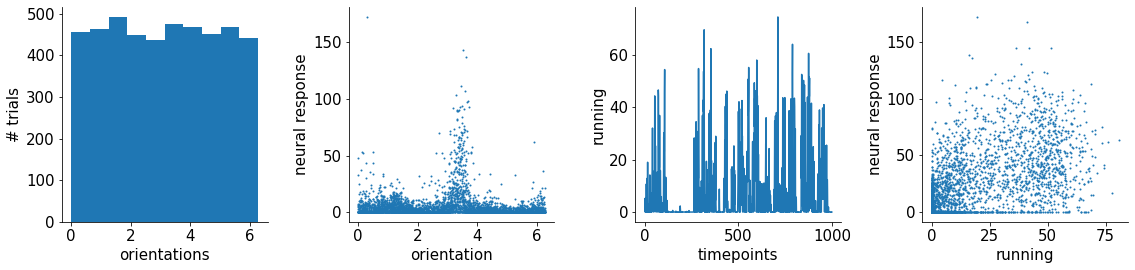

In [ ]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [ ]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components = 200).fit_transform(Z.T)

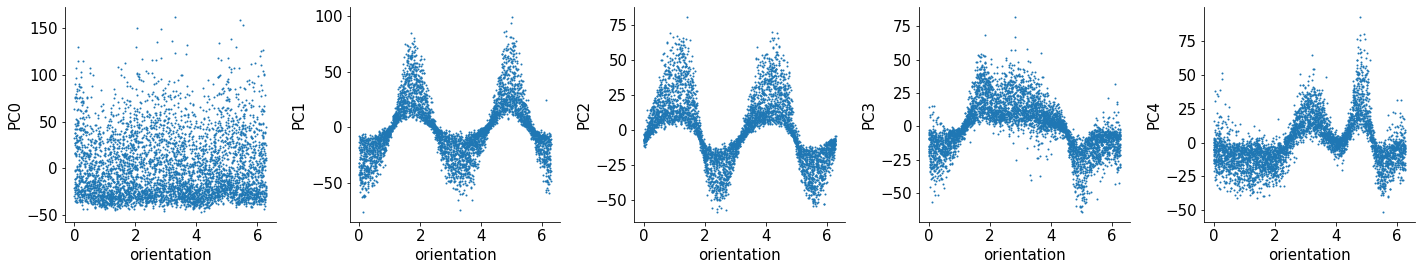

In [ ]:
#@title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1,5,j+1)
  plt.scatter(dat['istim'], X[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

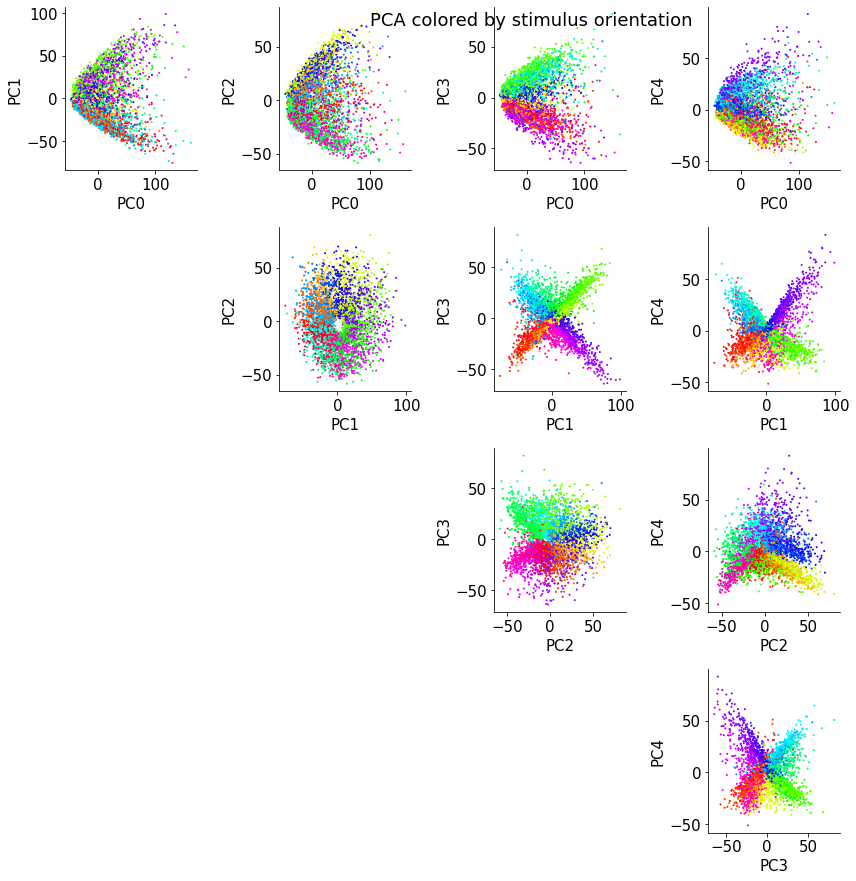

In [ ]:
n_components = 5
plt.figure(figsize=(15,15))
for i in range(n_components):
  for j in range(i+1, n_components):
    ax = plt.subplot(n_components, n_components, (n_components) * i + j)
    plt.scatter(X[:,i], X[:,j], c=dat['istim'], s=1, cmap='hsv')
    ax.set(xlabel='PC%d'%i, ylabel='PC%d'%j)
plt.suptitle('PCA colored by stimulus orientation')
plt.show()

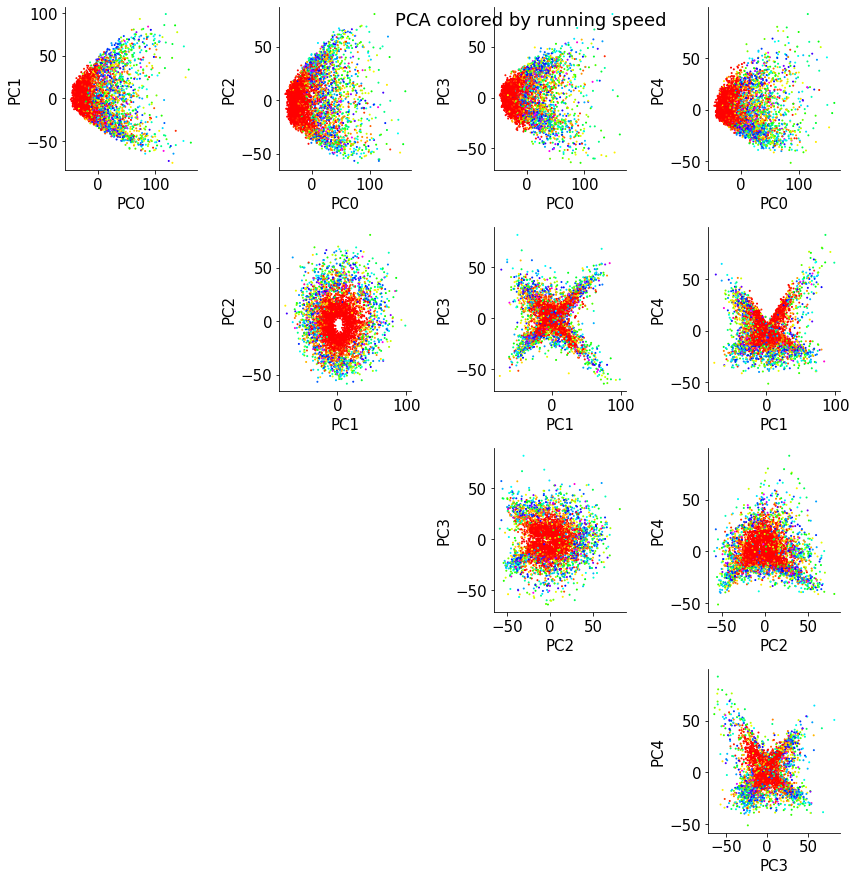

In [ ]:
n_components = 5
plt.figure(figsize=(15,15))
for i in range(n_components):
  for j in range(i+1, n_components):
    ax = plt.subplot(n_components, n_components, (n_components) * i + j)
    plt.scatter(X[:,i], X[:,j], c=dat['run'], s=1, cmap='hsv')
    ax.set(xlabel='PC%d'%i, ylabel='PC%d'%j)
plt.suptitle('PCA colored by running speed')
plt.show()

In [ ]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn
from umap import UMAP
ncomp = 3 # try 2, then try 3
xinit = 3 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)

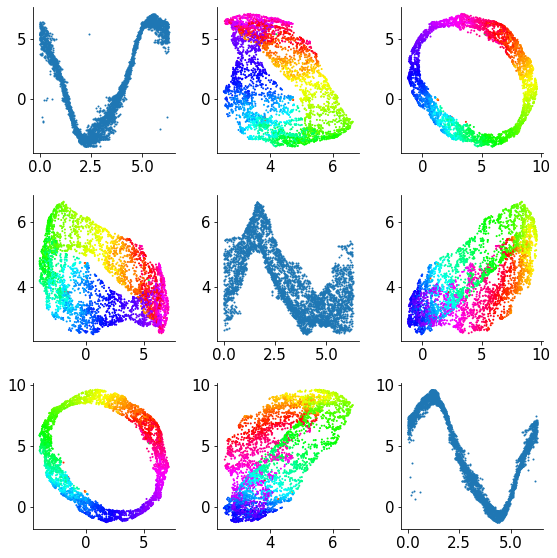

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i==j:
      plt.scatter(dat['istim'], embed[:,i], s  = 1)
    else:
      plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')
# Is that a Mobius strip? A good project would be to try to figure out why (I don't know). 

In [ ]:
print('Uilki was here')